## **Loading the dataset**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("database.csv")

In [3]:
df.shape

(23412, 21)

In [4]:
df.shape

(23412, 21)

In [5]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Dista

In [6]:
df.isna().sum()

,0
Date,0
Time,0
Latitude,0
Longitude,0
Type,0
Depth,0
Depth Error,18951
Depth Seismic Stations,16315
Magnitude,0
Magnitude Type,3


In [7]:
# Collating date and time to 1 col
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], errors="coerce")
df.drop(columns=["Date", "Time"], inplace=True)

## Dropping values in the columns which have more than 70% missing data. Then we impute the missing values in other columns by their respective median

In [8]:
# Drop columns with more than 70% missing values
missing_threshold = 0.7 * len(df)
df.dropna(thresh=missing_threshold, axis=1, inplace=True)

In [9]:
# Imputing missing values with median
df.fillna(df.median(numeric_only=True), inplace=True)

In [10]:
df.drop(columns=["ID"], errors="ignore", inplace=True)

In [11]:
df.isna().sum()

,0
Latitude,0
Longitude,0
Type,0
Depth,0
Magnitude,0
Magnitude Type,3
Root Mean Square,0
Source,0
Location Source,0
Magnitude Source,0


## **Data Visualization**

 Earthquakes follow a power-law distribution, meaning smaller quakes are more common than large one


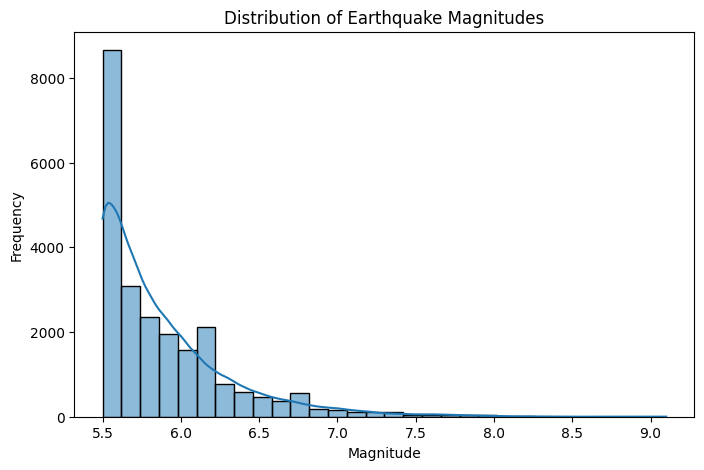

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(df["Magnitude"], bins=30, kde=True)
plt.title("Distribution of Earthquake Magnitudes")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.show()

Depth Distribiution to outliers and understand typical earthquake depths.

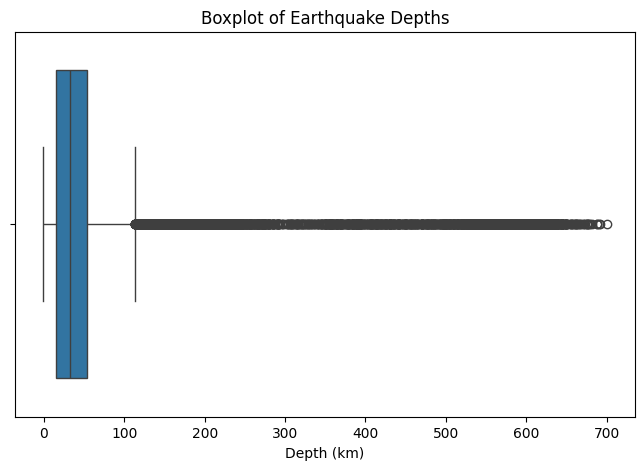

In [13]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["Depth"])
plt.title("Boxplot of Earthquake Depths")
plt.xlabel("Depth (km)")
plt.show()


Occurence graph for earthquakes over time

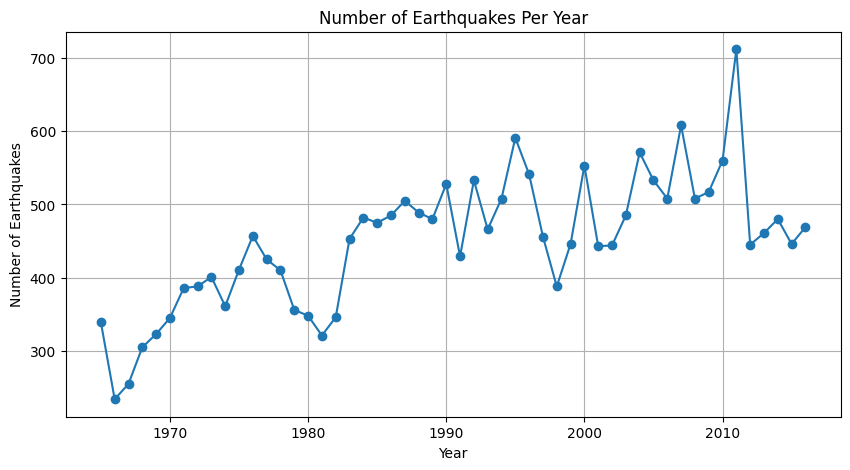

In [14]:
df["Year"] = df["Datetime"].dt.year
yearly_counts = df.groupby("Year").size()

plt.figure(figsize=(10, 5))
plt.plot(yearly_counts, marker="o", linestyle="-")
plt.title("Number of Earthquakes Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Earthquakes")
plt.grid()
plt.show()

Geographic Distribution for earthquakes

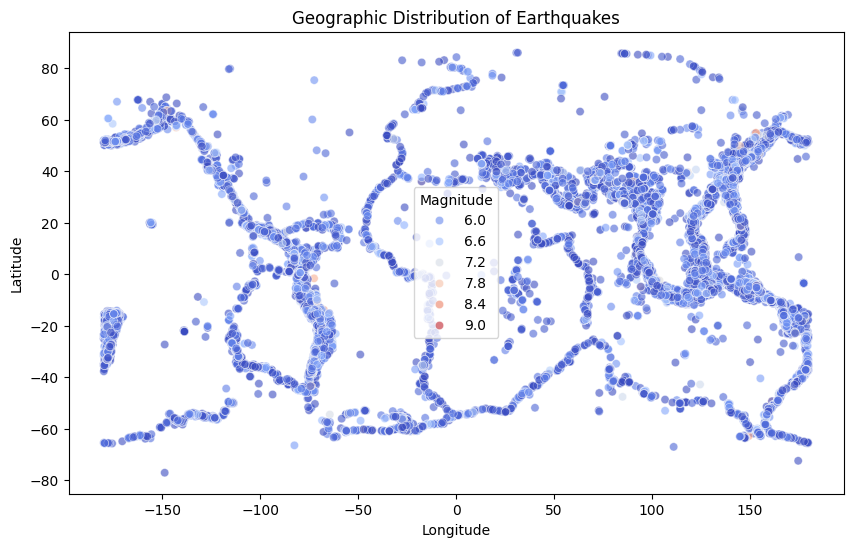

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["Longitude"], y=df["Latitude"], hue=df["Magnitude"], palette="coolwarm", alpha=0.6)
plt.title("Geographic Distribution of Earthquakes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Magnitude")
plt.show()


Correlation Heatmap for numerical features

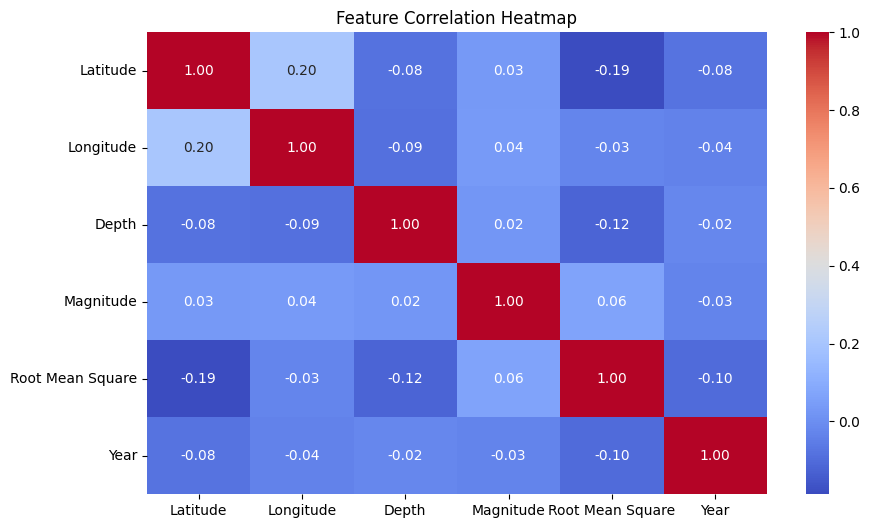

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Magnitude vs. Depth (Scatter Plot)

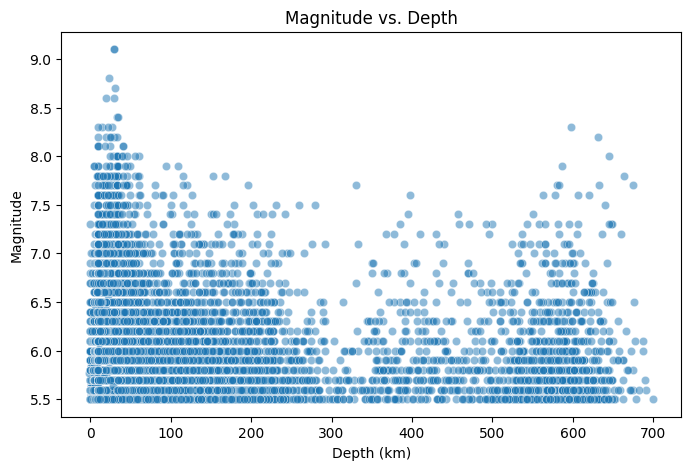

In [17]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["Depth"], y=df["Magnitude"], alpha=0.5)
plt.title("Magnitude vs. Depth")
plt.xlabel("Depth (km)")
plt.ylabel("Magnitude")
plt.show()

# **Prepare data for training the Random Forest Regressor**

In [18]:
df.columns

Index(['Latitude', 'Longitude', 'Type', 'Depth', 'Magnitude', 'Magnitude Type',
       'Root Mean Square', 'Source', 'Location Source', 'Magnitude Source',
       'Status', 'Datetime', 'Year'],
      dtype='object')

In [19]:
num_features = ["Latitude", "Longitude", "Depth", "Magnitude", "Root Mean Square", "Year"]
cat_features = ["Type", "Magnitude Type", "Status", "Source", "Location Source", "Magnitude Source"]
df_cleaned = df.dropna(subset=["Magnitude Type", "Datetime", "Year"])

In [20]:
df_selected = df_cleaned[num_features + cat_features]

In [21]:
# One-Hot Encoding
df_encoded = pd.get_dummies(df_selected, columns=cat_features)

In [22]:
# Define target variable
target = "Magnitude"
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (18724, 103)
Testing Data Shape: (4682, 103)


## **Training our model**

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Training
rf_model.fit(X_train, y_train)

# Predicting
y_pred = rf_model.predict(X_test)

## **Evaluating our model**

In [25]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.2844
Mean Squared Error (MSE): 0.1553
R² Score: 0.1519


## **Hyperparameter tuning using RandomizedCV**

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


rf = RandomForestRegressor(random_state=42)


random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='r2',
    random_state=42
)


random_search.fit(X_train, y_train)

# Print the best parameters
print("Best Hyperparameters:", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}


In [27]:
best_params = random_search.best_params_

best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Making predictions with tuned model
y_pred_best = best_rf.predict(X_test)

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_new = mean_absolute_error(y_test, y_pred_best)
mse_new = mean_squared_error(y_test, y_pred_best)
r2_new = r2_score(y_test, y_pred_best)

print(f"Optimized Mean Absolute Error (MAE): {mae_new:.4f}")
print(f"Optimized Mean Squared Error (MSE): {mse_new:.4f}")
print(f"Optimized R² Score: {r2_new:.4f}")

Optimized Mean Absolute Error (MAE): 0.2782
Optimized Mean Squared Error (MSE): 0.1491
Optimized R² Score: 0.1857


## **Plot Feature Importance**

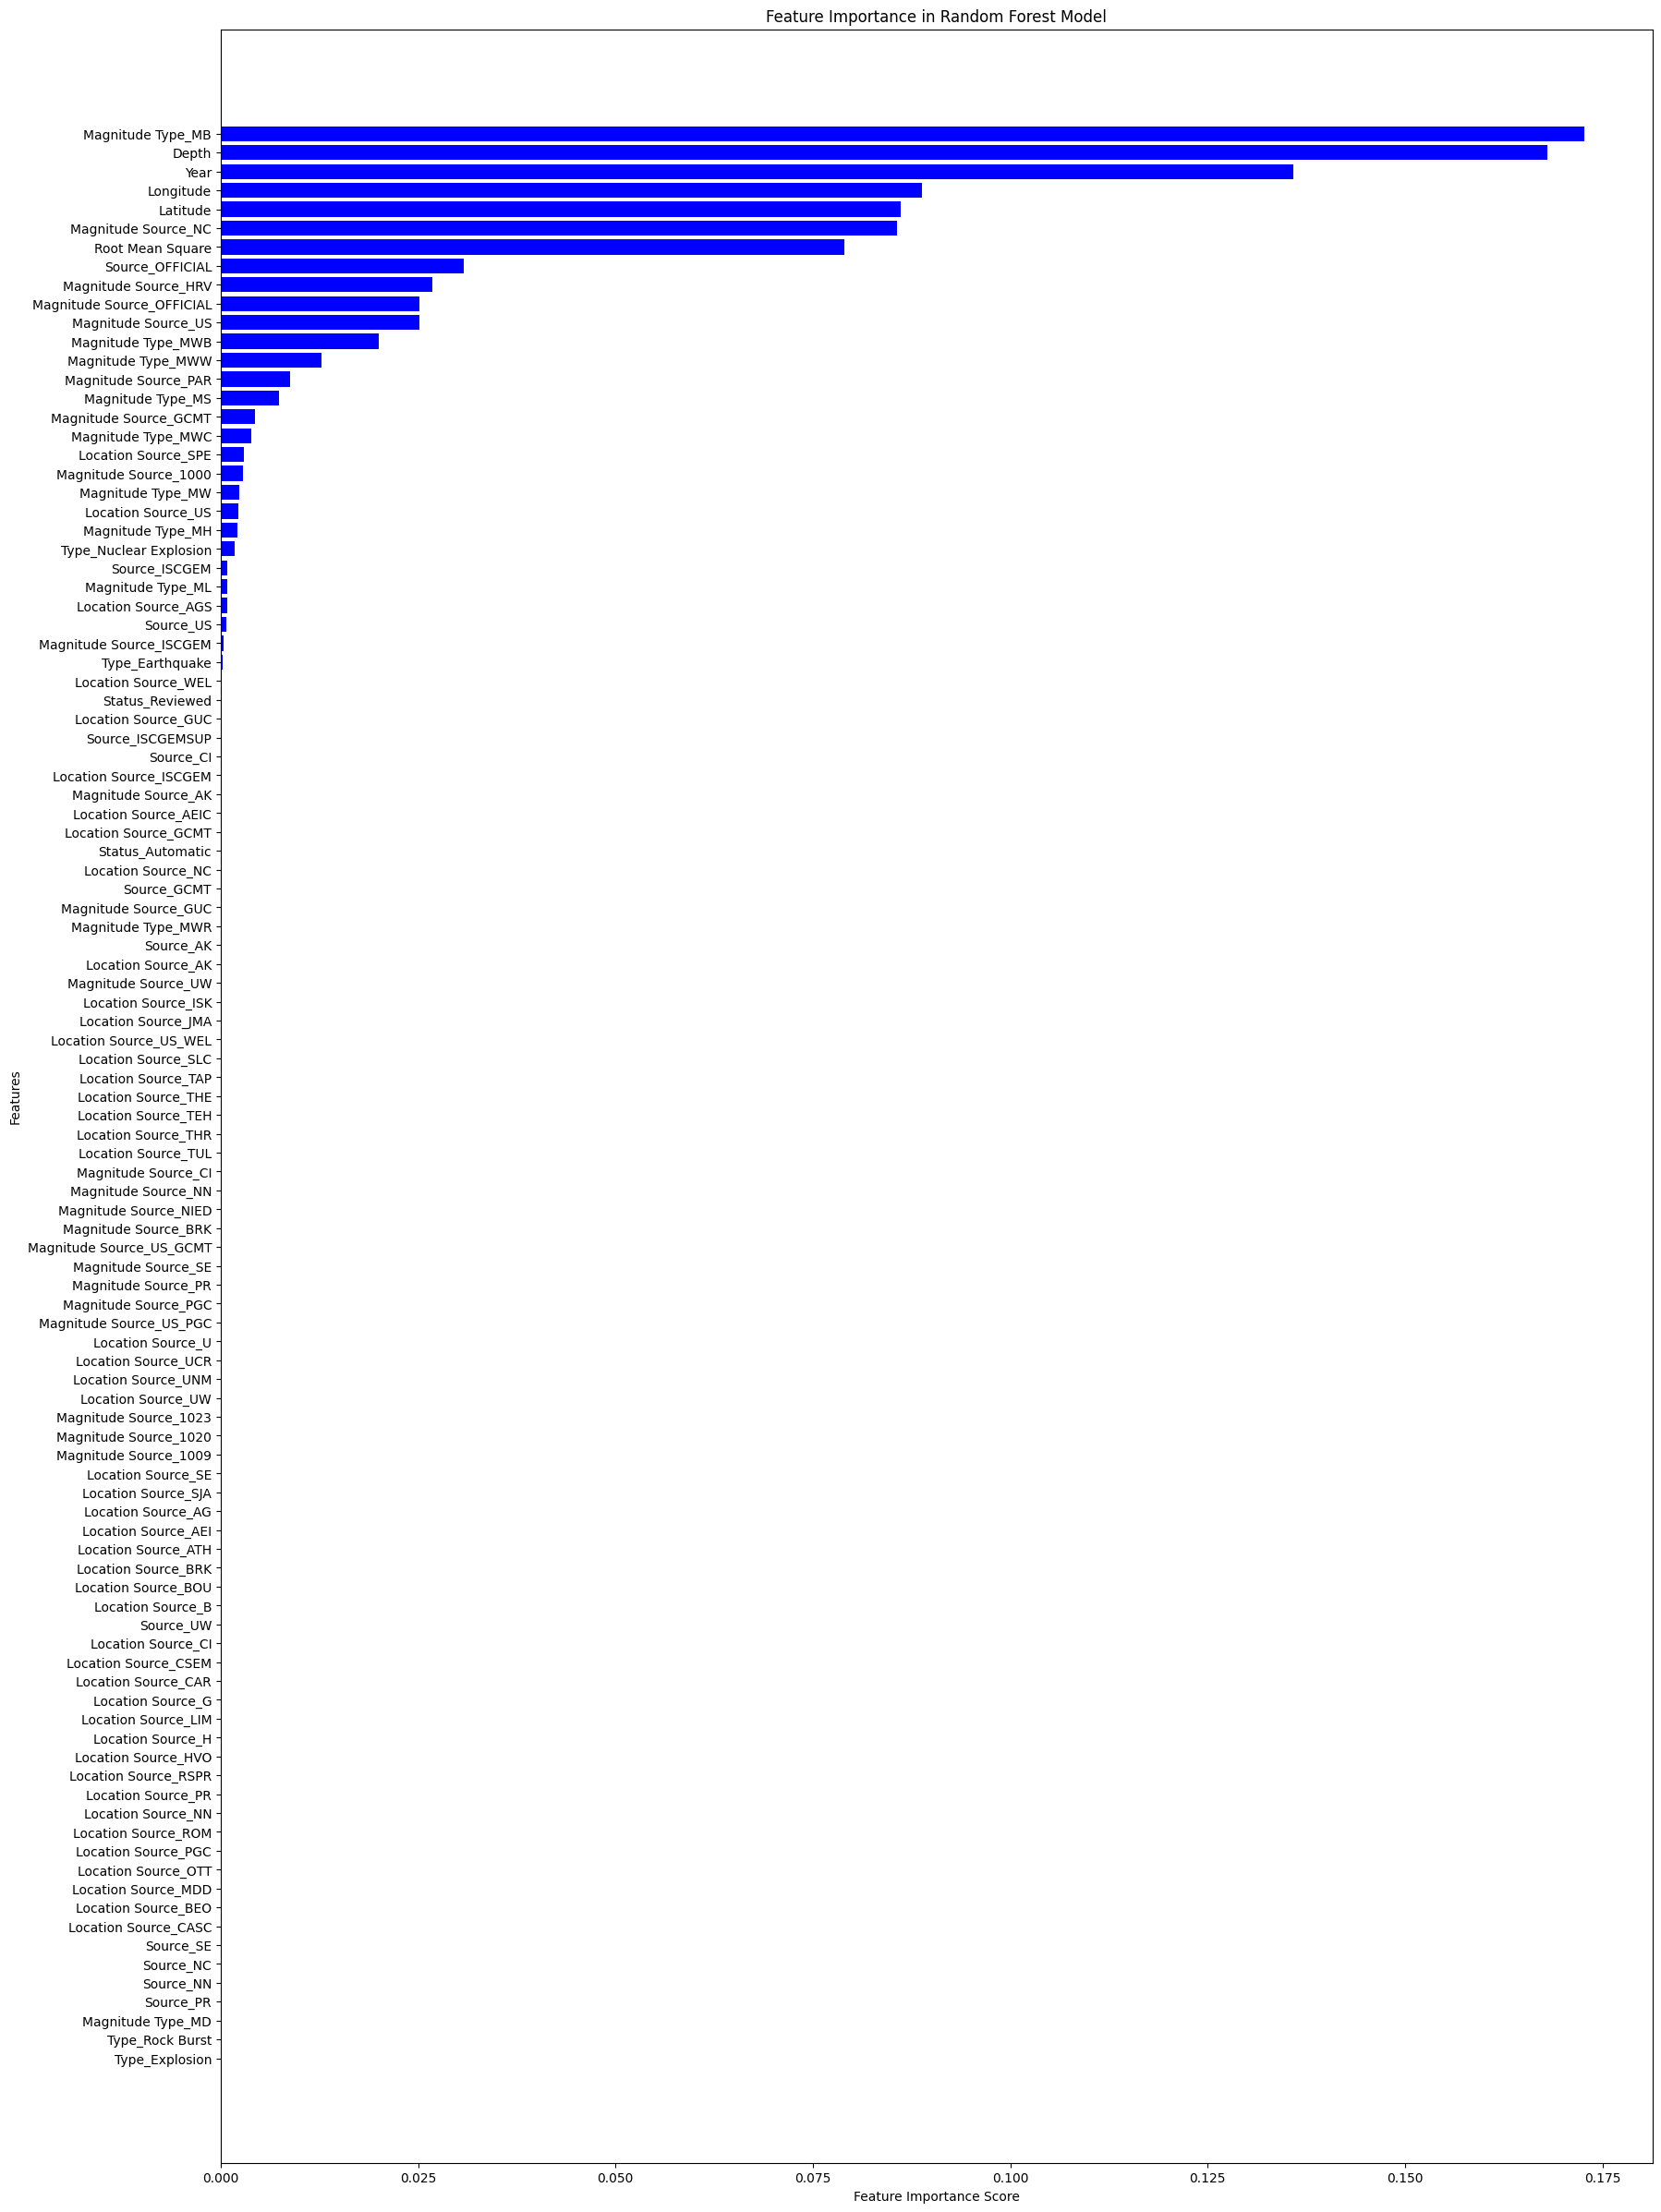

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = best_rf.feature_importances_
feature_names = X_train.columns

sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(20,30))
plt.barh(np.array(feature_names)[sorted_indices], importances[sorted_indices], color='blue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()


In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simple neural network model
nn_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
# Compile the model
nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [32]:
# Train the model
history = nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.4904 - mae: 1.9233 - val_loss: 0.2600 - val_mae: 0.3213
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4603 - mae: 0.3261 - val_loss: 0.2061 - val_mae: 0.2888
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1985 - mae: 0.3024 - val_loss: 0.2050 - val_mae: 0.3002
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1795 - mae: 0.3004 - val_loss: 0.2142 - val_mae: 0.2908
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1971 - mae: 0.2982 - val_loss: 0.2261 - val_mae: 0.3431
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1883 - mae: 0.3024 - val_loss: 0.1950 - val_mae: 0.2939
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1744 - mae: 0.2992 - val_loss: 0.1963 - val_mae: 0.2963
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1724 - mae: 0.2905 - val_loss: 0.2145 - val_mae: 0.2994
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

In [33]:
# Evaluate on test set
y_pred_nn = nn_model.predict(X_test_scaled)

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [34]:
# Compute metrics
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

In [35]:
print(f"Neural Network Mean Absolute Error (MAE): {mae_nn:.4f}")
print(f"Neural Network Mean Squared Error (MSE): {mse_nn:.4f}")
print(f"Neural Network R² Score: {r2_nn:.4f}")

Neural Network Mean Absolute Error (MAE): 0.2868
Neural Network Mean Squared Error (MSE): 0.1830
Neural Network R² Score: 0.0007


In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# feedforward neural network
nn_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [38]:
history = nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.5230 - mae: 1.9406 - val_loss: 0.3054 - val_mae: 0.3199
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2871 - mae: 0.3171 - val_loss: 0.2655 - val_mae: 0.3013
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2087 - mae: 0.3004 - val_loss: 0.1770 - val_mae: 0.2784
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1703 - mae: 0.2952 - val_loss: 0.2235 - val_mae: 0.2956
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1991 - mae: 0.3020 - val_loss: 0.1806 - val_mae: 0.2756
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1987 - mae: 0.3025 - val_loss: 0.2663 - val_mae: 0.2884
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2199 - mae: 0.2991 - val_loss: 0.1748 - val_mae: 0.2859
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1711 - mae: 0.2943 - val_loss: 0.1792 - val_mae: 0.2846
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [39]:
# Evaluate on test set
y_pred_nn = nn_model.predict(X_test_scaled)

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [40]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [41]:
# Define a GRU model
gru_model = keras.Sequential([
    layers.GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.GRU(64, activation='tanh', return_sequences=True),
    layers.GRU(32, activation='tanh'),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [43]:
gru_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 107s 216ms/step - loss: 3.7060 - mae: 0.9675 - val_loss: 0.1691 - val_mae: 0.3006
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 104s 221ms/step - loss: 0.1801 - mae: 0.3159 - val_loss: 0.1689 - val_mae: 0.3003
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 101s 216ms/step - loss: 0.1774 - mae: 0.3125 - val_loss: 0.1734 - val_mae: 0.3260
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 216ms/step - loss: 0.1827 - mae: 0.3192 - val_loss: 0.1695 - val_mae: 0.3129
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 147s 227ms/step - loss: 0.1785 - mae: 0.3156 - val_loss: 0.1695 - val_mae: 0.3136
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 119s 252ms/step - loss: 0.1798 - mae: 0.3140 - val_loss: 0.1684 - val_mae: 0.3021
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 129s 225ms/step - loss: 0.1759 - mae: 0.3126 - val_loss: 0.1682 - val_mae: 0.3022
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 138s 217ms/step - loss: 0.1794 - mae: 0.3140 - val_loss: 0.1683 - val_mae: 0.3069
Epoch 9/100
469/

In [44]:
y_pred_gru = gru_model.predict(X_test_scaled)

147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step


In [45]:
conv1d_model = keras.Sequential([
    layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    layers.Conv1D(64, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(32, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
conv1d_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [47]:
conv1d_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 9.7644 - mae: 2.1566 - val_loss: 0.1780 - val_mae: 0.3087
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1844 - mae: 0.3167 - val_loss: 0.1685 - val_mae: 0.3010
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1772 - mae: 0.3134 - val_loss: 0.1661 - val_mae: 0.2977
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.1832 - mae: 0.3148 - val_loss: 0.1794 - val_mae: 0.3441
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1828 - mae: 0.3182 - val_loss: 0.1642 - val_mae: 0.3027
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1819 - mae: 0.3148 - val_loss: 0.1708 - val_mae: 0.3085
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.1773 - mae: 0.3101 - val_loss: 0.1625 - val_mae: 0.3009
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1811 - mae: 0.3148 - val_loss: 0.1666 - val_mae: 0.2942
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8

In [48]:
y_pred_conv1d = conv1d_model.predict(X_test_scaled)

147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [49]:
# Define an improved Bidirectional LSTM model
bilstm_model = keras.Sequential([
    layers.Bidirectional(layers.LSTM(128, activation='tanh', return_sequences=True), input_shape=(X_train.shape[1], 1)),
    layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32, activation='tanh')),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [50]:
bilstm_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005), loss='mse', metrics=['mae'])

In [51]:
bilstm_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 255s 525ms/step - loss: 2.3457 - mae: 0.7224 - val_loss: 0.2598 - val_mae: 0.4489
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 265s 531ms/step - loss: 0.1872 - mae: 0.3224 - val_loss: 0.1778 - val_mae: 0.2886
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 245s 522ms/step - loss: 0.1923 - mae: 0.3233 - val_loss: 0.1911 - val_mae: 0.2878
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 261s 520ms/step - loss: 0.1844 - mae: 0.3174 - val_loss: 0.1698 - val_mae: 0.3116
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 267s 531ms/step - loss: 0.1822 - mae: 0.3166 - val_loss: 0.1831 - val_mae: 0.3464
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 260s 528ms/step - loss: 0.1844 - mae: 0.3194 - val_loss: 0.1685 - val_mae: 0.3070
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 528ms/step - loss: 0.1814 - mae: 0.3167 - val_loss: 0.1757 - val_mae: 0.2852
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 263s 529ms/step - loss: 0.1779 - mae: 0.3106 - val_loss: 0.1758 - val_mae: 0.2796
Epoch 9/100
469/

In [52]:
y_pred_bilstm = bilstm_model.predict(X_test_scaled)

147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step


In [53]:
# Compute metrics
def safe_metrics(y_true, y_pred):
    y_pred = np.nan_to_num(y_pred)  # Replace NaN values with zero
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Metrics for all models
mae_nn, mse_nn, rmse_nn, r2_nn = safe_metrics(y_test, y_pred_nn)
mae_gru, mse_gru, rmse_gru, r2_gru = safe_metrics(y_test, y_pred_gru)
mae_conv1d, mse_conv1d, rmse_conv1d, r2_conv1d = safe_metrics(y_test, y_pred_conv1d)
mae_bilstm, mse_bilstm, rmse_bilstm, r2_bilstm = safe_metrics(y_test, y_pred_bilstm)

In [54]:
# Print results
print("Feedforward Neural Network:")
print(f"MAE: {mae_nn:.4f}, MSE: {mse_nn:.4f}, RMSE: {rmse_nn:.4f}, R²: {r2_nn:.4f}")

print("\nGRU Model:")
print(f"MAE: {mae_gru:.4f}, MSE: {mse_gru:.4f}, RMSE: {rmse_gru:.4f}, R²: {r2_gru:.4f}")

print("\nConv1D Model:")
print(f"MAE: {mae_conv1d:.4f}, MSE: {mse_conv1d:.4f}, RMSE: {rmse_conv1d:.4f}, R²: {r2_conv1d:.4f}")

print("\nBidirectional LSTM Model:")
print(f"MAE: {mae_bilstm:.4f}, MSE: {mse_bilstm:.4f}, RMSE: {rmse_bilstm:.4f}, R²: {r2_bilstm:.4f}")

Feedforward Neural Network:
MAE: 0.2979, MSE: 0.1723, RMSE: 0.4151, R²: 0.0590

GRU Model:
MAE: 0.2865, MSE: 0.1551, RMSE: 0.3938, R²: 0.1530

Conv1D Model:
MAE: 0.2983, MSE: 0.1649, RMSE: 0.4060, R²: 0.0998

Bidirectional LSTM Model:
MAE: 0.2866, MSE: 0.1536, RMSE: 0.3919, R²: 0.1614


In [55]:
# Define an improved Bidirectional GRU model
bi_gru_model = keras.Sequential([
    layers.Bidirectional(layers.GRU(128, activation='tanh', return_sequences=True), input_shape=(X_train.shape[1], 1)),
    layers.Bidirectional(layers.GRU(64, activation='tanh', return_sequences=True)),
    layers.Bidirectional(layers.GRU(32, activation='tanh')),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
bi_gru_model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0005), loss='mse', metrics=['mae'])

In [57]:
bi_gru_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 228s 461ms/step - loss: 2.6278 - mae: 0.7945 - val_loss: 0.1678 - val_mae: 0.3105
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 263s 464ms/step - loss: 0.1812 - mae: 0.3167 - val_loss: 0.1881 - val_mae: 0.2801
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 463ms/step - loss: 0.1686 - mae: 0.3022 - val_loss: 0.1778 - val_mae: 0.2731
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 271s 484ms/step - loss: 0.1658 - mae: 0.2976 - val_loss: 0.1649 - val_mae: 0.3237
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 226s 483ms/step - loss: 0.1678 - mae: 0.3012 - val_loss: 0.1604 - val_mae: 0.3004
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 483ms/step - loss: 0.1636 - mae: 0.2965 - val_loss: 0.1634 - val_mae: 0.3183
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 261s 481ms/step - loss: 0.1620 - mae: 0.2947 - val_loss: 0.1887 - val_mae: 0.2840
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 215s 459ms/step - loss: 0.1604 - mae: 0.2918 - val_loss: 0.1507 - val_mae: 0.2741
Epoch 9/100
469/

In [58]:
y_pred_bi_gru = bilstm_model.predict(X_test_scaled)

147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step


In [59]:
#error metris for bi-directional gru model
mae_bi_gru, mse_bi_gru, rmse_bi_gru, r2_bi_gru = safe_metrics(y_test, y_pred_bi_gru)

In [60]:
print("\nBidirectional GRU Model:")
print(f"MAE: {mae_bi_gru:.4f}, MSE: {mse_bi_gru:.4f}, RMSE: {rmse_bi_gru:.4f}, R²: {r2_bi_gru:.4f}")


Bidirectional GRU Model:
MAE: 0.2866, MSE: 0.1536, RMSE: 0.3919, R²: 0.1614


In [61]:
# Define a Bidirectional + GRU + Conv1D model
bi_gru_conv_model = keras.Sequential([
    layers.Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Bidirectional(layers.GRU(128, activation='tanh', return_sequences=True)),
    layers.Bidirectional(layers.GRU(64, activation='tanh', return_sequences=True)),
    layers.Bidirectional(layers.GRU(32, activation='tanh')),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
bi_gru_conv_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [63]:
bi_gru_conv_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)


Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 128s 245ms/step - loss: 2.4882 - mae: 0.8155 - val_loss: 0.1622 - val_mae: 0.3049
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 118s 252ms/step - loss: 0.1721 - mae: 0.3079 - val_loss: 0.1562 - val_mae: 0.2692
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 138s 243ms/step - loss: 0.1620 - mae: 0.2932 - val_loss: 0.1505 - val_mae: 0.2916
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 146s 252ms/step - loss: 0.1656 - mae: 0.2966 - val_loss: 0.1560 - val_mae: 0.2666
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 114s 244ms/step - loss: 0.1627 - mae: 0.2930 - val_loss: 0.1471 - val_mae: 0.2680
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 244ms/step - loss: 0.1573 - mae: 0.2900 - val_loss: 0.1462 - val_mae: 0.2874
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 114s 244ms/step - loss: 0.1581 - mae: 0.2901 - val_loss: 0.1508 - val_mae: 0.3000
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 244ms/step - loss: 0.1603 - mae: 0.2920 - val_loss: 0.1441 - val_mae: 0.2694
Epoch 9/100
469/

In [64]:
y_pred_bi_gru_conv = bi_gru_conv_model.predict(X_test_scaled)

147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step


In [65]:
#error evaluation
mae_bi_gru_conv, mse_bi_gru_conv, rmse_bi_gru_conv, r2_bi_gru_conv = safe_metrics(y_test, y_pred_bi_gru_conv)

In [66]:
# Print results
print("Bidirectional GRU + Conv1D Model:")
print(f"MAE: {mae_bi_gru_conv:.4f}, MSE: {mse_bi_gru_conv:.4f}, RMSE: {rmse_bi_gru_conv:.4f}, R²: {r2_bi_gru_conv:.4f}")

Bidirectional GRU + Conv1D Model:
MAE: 0.2820, MSE: 0.1548, RMSE: 0.3934, R²: 0.1547


## Testing Extra Tress Regressor and Gradient Boosting Regressor

In [67]:
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor

# Define an Extra Trees Regressor
xtr_model = ExtraTreesRegressor(n_estimators=100, random_state=42)
xtr_model.fit(X_train_scaled, y_train)
y_pred_xtr = xtr_model.predict(X_test_scaled)

In [68]:
# Define a Gradient Boosting Regressor
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gbm_model.fit(X_train_scaled, y_train)
y_pred_gbm = gbm_model.predict(X_test_scaled)

In [69]:
#error metrics evaluation
mae_xtr, mse_xtr, rmse_xtr, r2_xtr = safe_metrics(y_test, y_pred_xtr)
mae_gbm, mse_gbm, rmse_gbm, r2_gbm = safe_metrics(y_test, y_pred_gbm)

In [70]:
# Print results
print("Extra Trees Regressor:")
print(f"MAE: {mae_xtr:.4f}, MSE: {mse_xtr:.4f}, RMSE: {rmse_xtr:.4f}, R²: {r2_xtr:.4f}")

print("Gradient Boosting Regressor:")
print(f"MAE: {mae_gbm:.4f}, MSE: {mse_gbm:.4f}, RMSE: {rmse_gbm:.4f}, R²: {r2_gbm:.4f}")

Extra Trees Regressor:
MAE: 0.2955, MSE: 0.1702, RMSE: 0.4126, R²: 0.0704
Gradient Boosting Regressor:
MAE: 0.2817, MSE: 0.1514, RMSE: 0.3891, R²: 0.1734


In [71]:
#SVR Integration
from sklearn.svm import SVR
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)

In [72]:
mae_svr, mse_svr, rmse_svr, r2_svr = safe_metrics(y_test, y_pred_svr)
print("Support Vector Regression Model:")
print(f"MAE: {mae_svr:.4f}, MSE: {mse_svr:.4f}, RMSE: {rmse_svr:.4f}, R²: {r2_svr:.4f}")


Support Vector Regression Model:
MAE: 0.2676, MSE: 0.1638, RMSE: 0.4048, R²: 0.1054
